## Inverted pendulum control, step-5: 
### Dynamic equations of the inverted pendulum in matrix form

Recall that the dynamic equations of the inverted pendulum can be written in matrix form given by:
$$\dot{\mathbf{s}} = \mathbf{A} \mathbf{s} + \mathbf{B}F$$

where,

\begin{equation}
\mathbf{s} = \left[ \begin{matrix}
x \\
\dot{x} \\
\theta \\
\dot{\theta} \\
\end{matrix} \right]
\end{equation}

\begin{equation}
\dot{\mathbf{s}} = \left[ \begin{matrix}
\dot{x} \\
\ddot{x} \\
\dot{\theta} \\
\ddot{\theta} \\
\end{matrix} \right]
\end{equation}

\begin{equation}
\mathbf{A} = \left[ \begin{matrix}
0 & 1 & 0 & 0 \\
0 & -\frac{(I + m l^2) \mu}{d} & \frac{(m l)^2 g}{d} & 0 \\
0 & 0 & 0 & 1 \\
0 & -\frac{m l \mu}{d} & \frac{(M+m) m g l}{d} & 0 \\
\end{matrix} \right]
\end{equation}

\begin{equation}
\mathbf{B} = \left[ \begin{matrix}
0\\
\frac{(I+m l^2)}{d}\\
0\\
\frac{m l}{d}\\
\end{matrix} \right]
\end{equation}

and 

\begin{equation}
\mathbf{s}_{t+T} = \left[ \mathbf{I} + T \mathbf{A} \right] \mathbf{s}_t  + T \mathbf{B}F_t 
\end{equation}

where, $\mathbf{I}$ is a $4 \times 4$ identity matrix, $\mathbf{s}_{t+T}$ is $\mathbf{s}$ at time $t+T$ and $\mathbf{s}_t$ is $\mathbf{s}$ at time $t$, and $T$ is the sampling step.

Given a control law given by
\begin{equation}
F_t = -\mathbf{K} \mathbf{s}_t
\end{equation}

Write a code to iteratively update the value of $\mathbf{s}_t$ for $t = 0,T,2T,...,8000T$. Plot cart position, cart velocity, pendulum angle, and pendulum angular speed, and force over time.

Shape of s is (4000, 4)


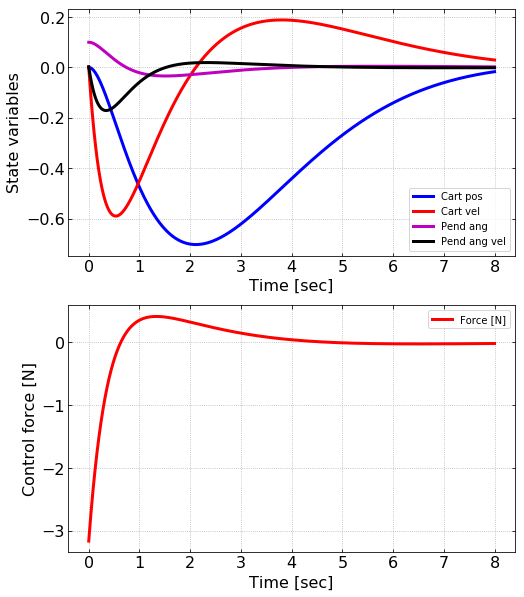

In [0]:
import numpy as np
import matplotlib.pyplot as plt

def pendulum_matrix():
    m = 0.1        # Mass of the pendulum
    M = 1          # Mass of the cart
    l = 1          # Length of the pendulum
    I = 0.5*m*l**2 # Moment of inertia of the pendulum
    beta = 0.3     # Friction of the cart
    g = 9.81       # Acceleration of gravity
    
    den = I*(M+m) + M*m*l**2
    
    A = np.array([[0, 1, 0, 0],[0, -(I + m*l**2)*beta/den, ((m*l)**2)*g/den, 0],[0,0,0,1],[0,-m*l*beta/den,(M+m)*m*g*l/den,0]])
    B = np.array([0,(I+m*l**2)/den,0,m*l/den])
    return A, B

def pendulum_dynamics(state, A, B, force):
    #I = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])
    I = np.eye(4)
    T = 0.002 # Sampling step

    Ab = np.array(I+T*A)
    state = np.dot(Ab,state) + T*np.dot(B,force)
    state = np.array(state)
    return state

def controller(K, state):
    force = -np.dot(K,np.transpose(state))
    return force


state = np.array([0, 0, 0.1, 0]) # Initial states - cart position, cart velocity, pendulum angle, pendulum angular velocity
K = np.array([-0.4472, -1.7709, 31.3293, 12.0004])

A, B = pendulum_matrix() # Call the function to obtain A and B matrices

force = 1
d = []
s = []
T = 0.002
N = 4000

for i in range(N): # Loop for N*T seconds
    state = pendulum_dynamics(state, A, B, force) # Obtain the next value of the state vector
    force = controller(K, state) # Call the controller function to obtain the force to push/pull the cart
    
    s.append(state)
    d.append([i*T, force])
    
d = np.array(d)
s = np.array(s)
print("Shape of s array is", s.shape)

# Create the figure

fig, axes = plt.subplots(nrows=2)

# First we draw into the first axes (i.e. subplot) of the figure

axes[0].plot(d[:,0], s[:,0], 'b-', label='Cart pos', linewidth=3)
axes[0].plot(d[:,0], s[:,1], 'r-', label='Cart vel', linewidth=3)
axes[0].plot(d[:,0], s[:,2], 'm-', label='Pend ang', linewidth=3)
axes[0].plot(d[:,0], s[:,3], 'k-', label='Pend ang vel', linewidth=3)

axes[0].legend(loc='lower right')
axes[0].set_xlabel('Time [sec]', fontsize=16);
axes[0].set_ylabel('State variables', fontsize=16)
axes[0].tick_params(labelsize=16)

# Now we draw into the second axes (i.e. subplot) of the figure

axes[1].plot(d[:,0], d[:,1], 'r-', linewidth=3, label='Force [N]')
axes[1].set_xlabel('Time [sec]', fontsize=16)
axes[1].set_ylabel('Control force [N]', fontsize=16)
axes[1].tick_params(labelsize=16)
axes[1].legend(loc='upper right')

# Now we are going to do some formatting of the figure itself
# such as adding tick marks along the axis of the plots and
# adding gridlines for better readability of the graph.

for i, a in enumerate(fig.axes):
        a.tick_params(direction='in', grid_linestyle=":", top=True, right=True)
        a.grid(which='major', axis='both', linestyle=":")

fig.set_size_inches(8,10)
plt.show()

## ALTERNATIVE SOLUTION: Rule based control - 1

Another approach to control the inverted pendulum is to use a heuristic rule based approach. Following is a simple example that generates forces on the cart only based on the pendulum angle and angular speed. You can improve it by adding rules using pendulum angle and other states.

Shape of s array is (4000, 4)


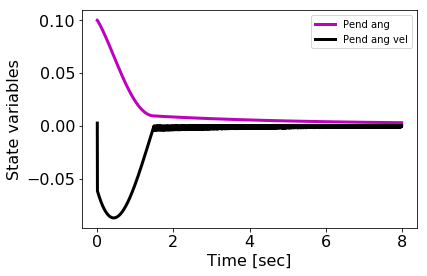

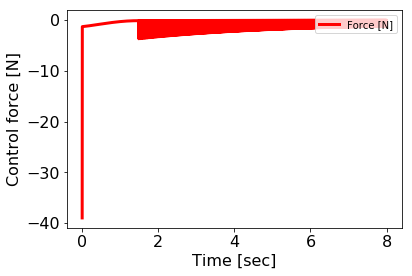

In [0]:
import numpy as np
import matplotlib.pyplot as plt


def pendulum_matrix():
    m = 0.1        # Mass of the pendulum
    M = 1          # Mass of the cart
    l = 1          # Length of the pendulum
    I = 0.5*m*l**2 # Moment of inertia of the pendulum
    beta = 0.3     # Friction of the cart
    g = 9.81       # Acceleration of gravity
    
    den = I*(M+m) + M*m*l**2
    
    A = np.array([[0, 1, 0, 0],[0, -(I + m*l**2)*beta/den, ((m*l)**2)*g/den, 0],[0,0,0,1],[0,-m*l*beta/den,(M+m)*m*g*l/den,0]])
    B = np.array([0,(I+m*l**2)/den,0,m*l/den])
    return A, B


def pendulum_dynamics(state, A, B, force):
    #I = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])
    I = np.eye(4)
    T = 0.002 # Sampling step

    Ab = np.array(I+T*A)
    state = np.dot(Ab,state) + T*np.dot(B,force)
    state = np.array(state)
    return state


def angPL(ang,angv):
    force = 0
    ub = 0.1 # Upper bound
    gain = 13
    if (ang >= 0) and (ang <= ub) and (angv >= 0):
        force = -30*gain*ang
    elif (ang >= 0) and (ang <= ub) and (angv < 0):
        force = -gain*ang
    elif (ang >= ub) and (angv >= 0):
        force = -20*gain*ang
    elif (ang >= ub) and (angv <= 0):
        force = -10*gain*ang
    return force


def angNL(ang,angv):
    force = 0
    lb = -0.1 # Lower bound
    gain = 13
    if (ang <= 0) and (ang >= lb) and (angv >= 0):
        force = 30*gain*ang
    elif (ang <= 0) and (ang >= lb) and (angv <= 0):
        force = gain*ang;
    elif (ang <= lb) and (angv <= 0):
        force = 20*gain*ang;
    elif (ang <= lb) and (angv >= 0):
        force = 10*gain*ang;
    return force


def rule_controller(state):
    ang = state[2]
    angv = state[3]
    forcePL = angPL(ang, angv)
    forceNL = angNL(ang, angv)
    
    force = forcePL + forceNL
    return force
    
state = np.array([0, 0, 0.1, 0]) # Initial states - cart position, cart velocity, pendulum angle, pendulum angular velocity
K = np.array([-0.4472, -1.7709, 31.3293, 12.0004])

A, B = pendulum_matrix() # Call the function to obtain A and B matrices

force = 1
d = []
s = []
T = 0.002
N = 4000
for i in range(N): # Loop for N*T seconds
    state = pendulum_dynamics(state, A, B, force) # Obtain the next value of the state vector
    force = rule_controller(state) # Call the controller function to obtain the force to push/pull the cart
    
    s.append(state)
    d.append([i*T,force])
    
d = np.array(d)
s = np.array(s)
print("Shape of s array is", s.shape)

# Figure 1

# plt.plot(d[:,0], s[:,0], 'b-', label='Cart pos', linewidth=3)
# plt.plot(d[:,0], s[:,1], 'r-', label='Cart vel', linewidth=3)
plt.plot(d[:,0], s[:,2], 'm-', label='Pend ang', linewidth=3);
plt.plot(d[:,0], s[:,3], 'k-', label='Pend ang vel', linewidth=3)

plt.legend(loc='upper right')
plt.xlabel('Time [sec]', fontsize=16)
plt.ylabel('State variables', fontsize=16)
plt.tick_params(labelsize=16)
plt.show()

# Figure 2

plt.plot(d[:,0], d[:,1], 'r-', linewidth=3, label='Force [N]')
plt.xlabel('Time [sec]', fontsize=16)
plt.ylabel('Control force [N]', fontsize=16)
plt.tick_params(labelsize=16)
plt.legend(loc='upper right')
plt.show()